In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
import spacy
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from textblob import TextBlob


In [11]:
from gensim.models import FastText
fasttext_model = FastText.load_fasttext_format('cc.pt.300.bin')


C:\Users\igord\AppData\Local\Temp\ipykernel_5896\3474075851.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format('cc.pt.300.bin')


In [3]:
df = pd.read_excel('df.xlsx')
df = df.query('Quem == "Candidato"')

In [31]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igord\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igord\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import re
import nltk
import spacy
import pandas as pd
from nltk.corpus import stopwords

# Carregue o modelo de idioma português spaCy
nlp = spacy.load('pt_core_news_sm')

# Baixe as stopwords em português, caso ainda não tenha feito
nltk.download('stopwords')
portuguese_stopwords = stopwords.words('portuguese')

def preprocess_text(text):
    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-ZÀ-ú\s]', '', text)

    # Converter para minúsculas
    text = text.lower()

    # Tokenização
    words = nltk.word_tokenize(text)

    # Remover stopwords
    words = [word for word in words if word not in portuguese_stopwords]

    # Lematização
    lemmatized_words = [token.lemma_ for token in nlp(' '.join(words))]

    return lemmatized_words

# Aplicar o pré-processamento no DataFrame
df['Texto_preprocessado'] = df['Texto'].apply(preprocess_text)

# Exibir as primeiras linhas do DataFrame
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igord\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   dia  Ordem       Quem            Nome   
0    1      2  Candidato  Jair Bolsonaro  \
1    1      4  Candidato  Jair Bolsonaro   
2    1      6  Candidato  Jair Bolsonaro   
3    1      8  Candidato  Jair Bolsonaro   
4    1     10  Candidato  Jair Bolsonaro   

                                               Texto   
0  Primeiro, você não está falando a verdade quan...  \
1               Sim, e ele vinha fazendo contra mim.   
2  Você falou ministros, falou ministros. Foi um ...   
3  Quem vem sendo perseguido o tempo todo por um ...   
4  Fique tranquilo, Bonner. Teremos eleições. O m...   

                                 Texto_preprocessado  
0  [primeiro, falar, verdade, falar, xingar, mini...  
1                      [sim, vir, fazer, contra, eu]  
2  [falar, ministro, falar, ministro, ministro, e...  
3  [vir, ser, perseguir, tempo, todo, ministro, S...  
4  [ficar, tranquilo, bonner, eleição, ministro, ...  


In [36]:
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.downloader as api
import numpy as np
from collections import defaultdict

nltk.download('stopwords')
portuguese_stopwords = stopwords.words('portuguese')

# Carregar o modelo pré-treinado FastText em português
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

def count_topic_words(df, topics, similarity_threshold=0.6):
    topic_word_counts = defaultdict(int)

    for candidate in df['Nome'].unique():
        candidate_rows = df[df['Nome'] == candidate]
        
        # Converter listas de palavras em strings
        candidate_texts = [" ".join(words) for words in candidate_rows['Texto_preprocessado']]
        
        candidate_words = [gensim.utils.simple_preprocess(text, deacc=True) for text in candidate_texts]
        candidate_count_data = np.zeros((1, fasttext_model.vector_size))
        for words in candidate_words:
            for word in words:
                if word not in fasttext_model.key_to_index:
                    continue
                candidate_count_data[0, :] += fasttext_model[word]

        for topic in topics:
            if topic not in fasttext_model.key_to_index:
                continue

            topic_vector = fasttext_model[topic]
            similarity = np.dot(candidate_count_data, topic_vector.T) / np.linalg.norm(candidate_count_data) / np.linalg.norm(topic_vector)

            if similarity >= similarity_threshold:
                topic_word_counts[f"{candidate}_{topic}"] += candidate_count_data[0, :].sum()

    return topic_word_counts


# Definir os tópicos e palavras relacionadas
topics = ['educacao', 'saude', 'corrupcao', 'economia', 'emprego']

# Contar a frequência das palavras relacionadas aos tópicos
topic_word_counts = count_topic_words(df, topics)

# Imprimir os resultados
for candidate in df['Nome'].unique():
    print(f"\n{candidate}:")
    for topic in topics:
        print(f"{topic}: {topic_word_counts[f'{candidate}_{topic}']}")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igord\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Jair Bolsonaro:
educacao: 0
saude: 0
corrupcao: 0
economia: 1840.760166262805
emprego: 0

Ciro Gomes:
educacao: 0
saude: 0
corrupcao: 0
economia: 2147.479077534465
emprego: 0

Lula:
educacao: 0
saude: 0
corrupcao: 0
economia: 1821.6705074756926
emprego: 0

Simone Tebet:
educacao: 0
saude: 0
corrupcao: 0
economia: 2502.902815120804
emprego: 0

Felipe D'Avila:
educacao: 0
saude: 0
corrupcao: 0
economia: 918.5333509456118
emprego: 0

Soraya Thronicke:
educacao: 0
saude: 0
corrupcao: 0
economia: 742.8423339291444
emprego: 0


In [38]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\igord\AppData\Roaming\nltk_data...


True

In [8]:
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

# Análise de sentimentos
sia = SentimentIntensityAnalyzer()

def sentiment_scores(candidate_rows):
    # Converter palavras pré-processadas de volta para o formato de texto
    preprocessed_texts = [" ".join(words) for words in candidate_rows['Texto_preprocessado']]
    
    # Obter os scores de sentimento dos textos pré-processados
    candidate_scores = [sia.polarity_scores(text) for text in preprocessed_texts]
    
    return candidate_scores

def plot_sentiment_scores(df):
    # Obter os scores de sentimento para cada candidato
    scores = [sentiment_scores(df[df['Nome'] == candidate]) for candidate in df['Nome'].unique()]

    # Plotar comparação dos scores de sentimento dos textos de cada candidato
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(len(scores)):
        compound_scores = [score['compound'] for score in scores[i]]
        ax.plot(range(len(compound_scores)), compound_scores, label=df['Nome'].unique()[i])
    
    ax.set_xlabel('Texto')
    ax.set_ylabel('Sentiment Score')
    ax.set_title('Comparação dos Scores de Sentimento dos Textos')
    ax.legend()

    plt.show()

# Chame a função para plotar os scores de sentimento
plot_sentiment_scores(df)




KeyError: 'Texto_preprocessado'

In [62]:
import pandas as pd

# Criar um dataframe com os resultados do plot
results = {'Candidato': df['Nome'].unique(),
           'Score de Sentimento': [sentiment_scores(df[df['Nome'] == candidate]) for candidate in df['Nome'].unique()]}
df_results = pd.DataFrame(results)

# Salvar o dataframe como um arquivo CSV
df_results.to_csv('results.csv', index=False)



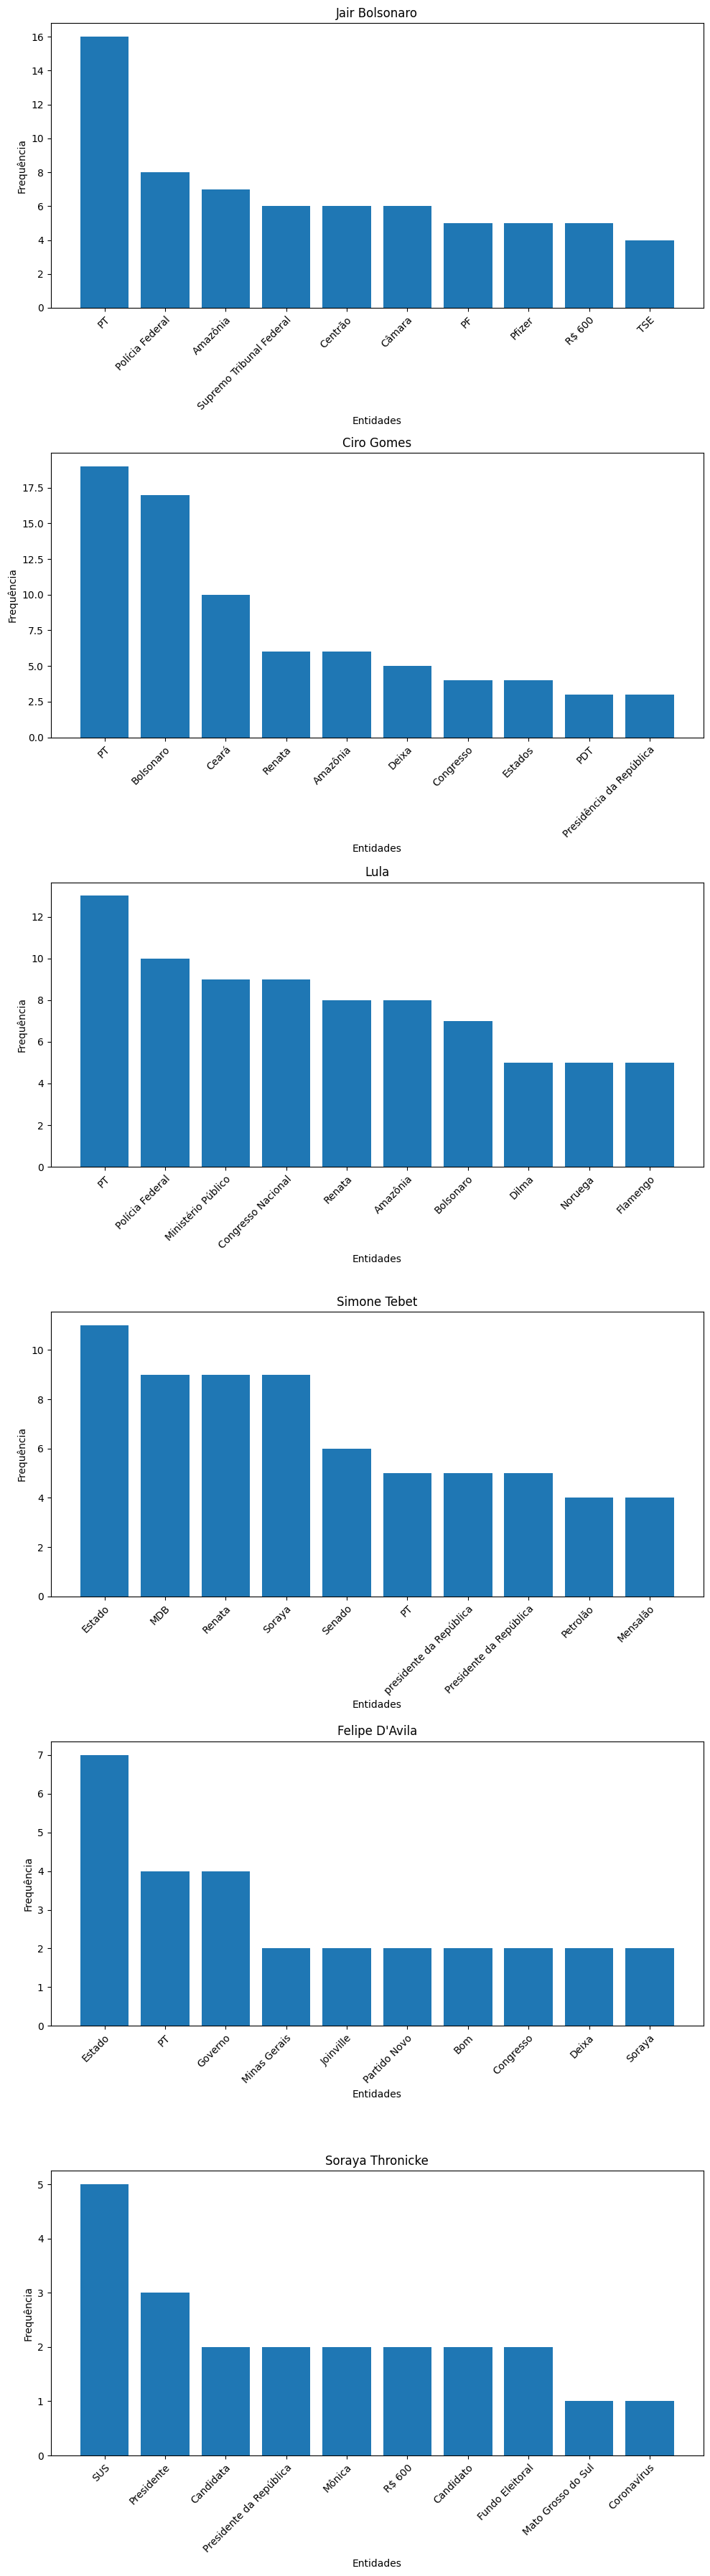

In [54]:
import matplotlib.pyplot as plt

# Palavras e entidades para ignorar
ignore_list = ["Brasil", "R$", "Real", "reais", "Sabe", "Olha", "Cadê", "Tenho", "Sim", "Fui", "Bonner", "Vera"]

# Função para filtrar entidades nomeadas
def filter_named_entities(named_entities):
    filtered_entities = []
    for entity, label in named_entities:
        if label != "PER" and entity not in ignore_list:
            filtered_entities.append((entity, label))
    return filtered_entities

# Atualizar entidades nomeadas após aplicar a filtragem
df['Entidades_nomeadas_filtradas'] = df['Entidades_nomeadas'].apply(filter_named_entities)

# Atualizar a contagem das entidades nomeadas filtradas por candidato
named_entities_counts_filtered = defaultdict(int)
for candidate in df['Nome'].unique():
    candidate_rows = df[df['Nome'] == candidate]
    for entities in candidate_rows['Entidades_nomeadas_filtradas']:
        for entity, label in entities:
            named_entities_counts_filtered[(candidate, entity, label)] += 1

# Atualizar o código de plotagem para usar entidades filtradas
top_n = 10
top_named_entities_filtered = defaultdict(list)

for candidate in df['Nome'].unique():
    candidate_entities = {key: value for key, value in named_entities_counts_filtered.items() if key[0] == candidate}
    sorted_candidate_entities = sorted(candidate_entities.items(), key=lambda x: x[1], reverse=True)
    top_named_entities_filtered[candidate] = sorted_candidate_entities[:top_n]

fig, axes = plt.subplots(len(df['Nome'].unique()), 1, figsize=(10, 6 * len(df['Nome'].unique())))
for i, candidate in enumerate(df['Nome'].unique()):
    entities = [ent[0][1] for ent in top_named_entities_filtered[candidate]]
    counts = [ent[1] for ent in top_named_entities_filtered[candidate]]
    axes[i].bar(entities, counts)
    axes[i].set_title(f"{candidate}")
    axes[i].set_xlabel('Entidades')
    axes[i].set_ylabel('Frequência')
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()




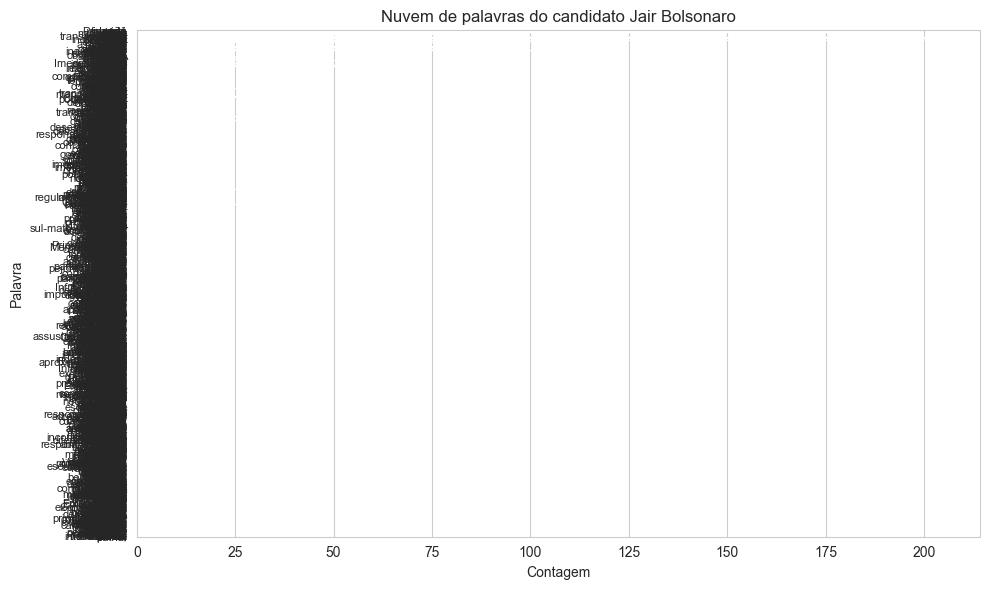

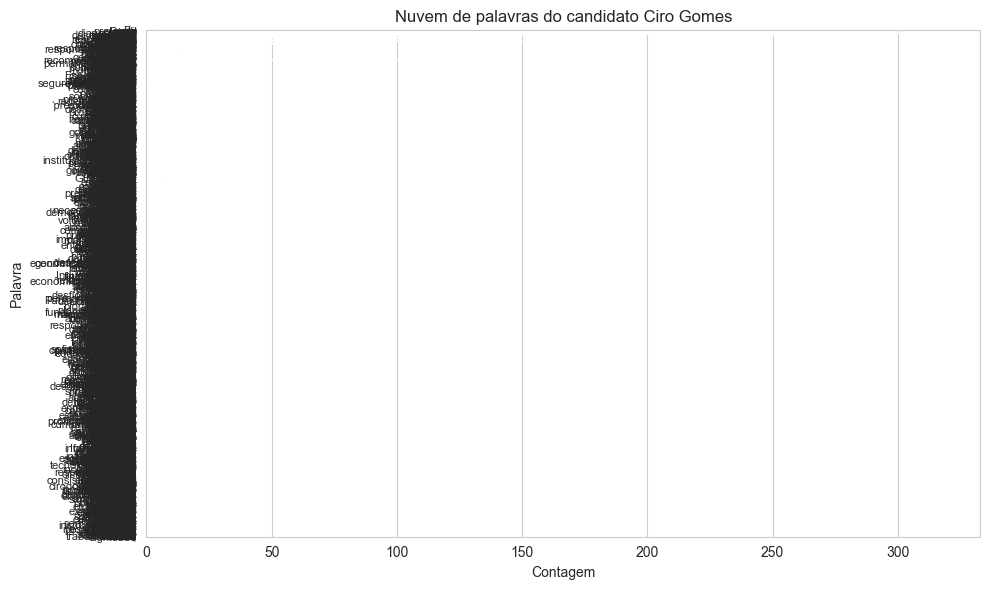

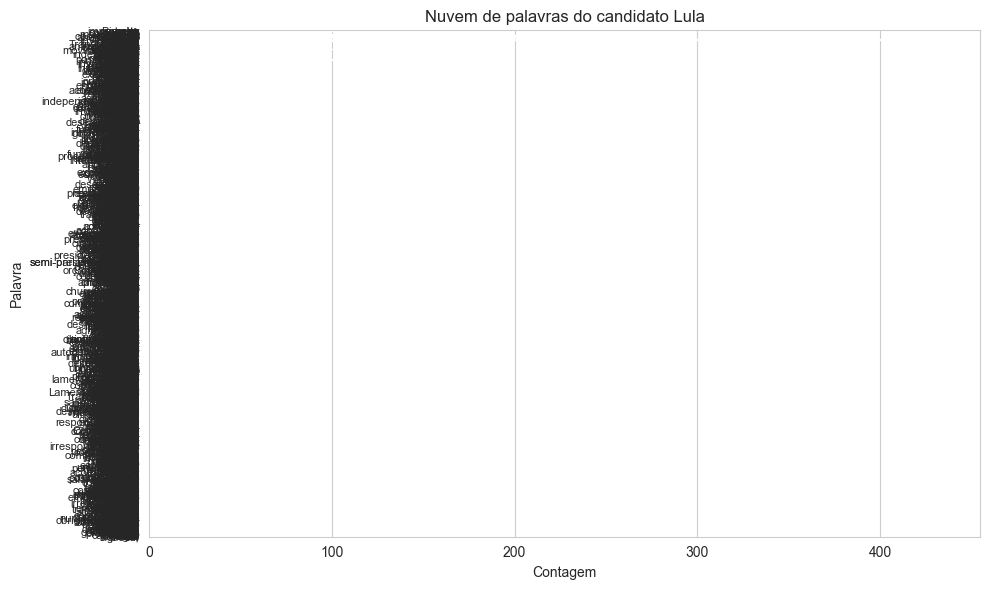

KeyboardInterrupt: 

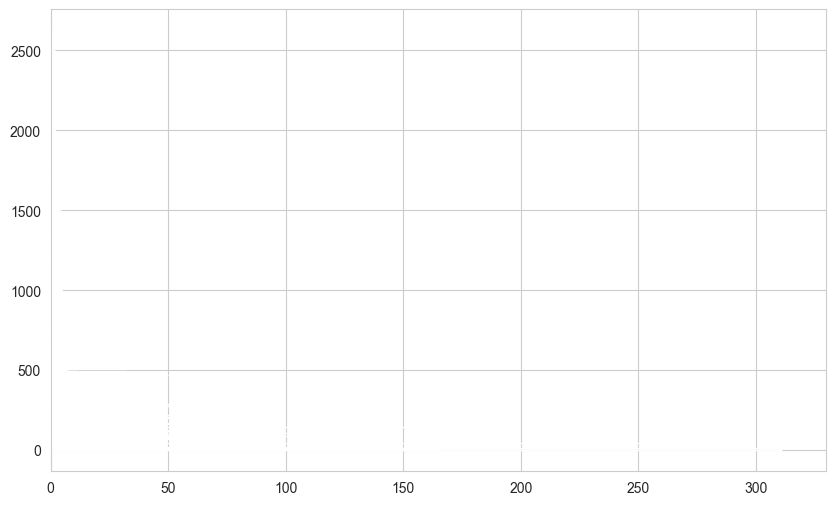

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Função para criar nuvem de palavras
def plot_wordcloud(candidate, text):
    # Cria um dicionário com as contagens de cada palavra
    word_counts = dict(Counter(text.split()))
    # Cria um gráfico de barras horizontais com as palavras e suas contagens
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(word_counts.values()), y=list(word_counts.keys()), palette="mako")
    ax.set_title(f"Nuvem de palavras do candidato {candidate}")
    ax.set_xlabel("Contagem")
    ax.set_ylabel("Palavra")
    ax.tick_params(axis="y", labelsize=8)
    plt.tight_layout()
    plt.show()

# Plotar nuvem de palavras para cada candidato
for candidate in df['Nome'].unique():
    candidate_text = " ".join(df[df['Nome'] == candidate]['Texto'])
    plot_wordcloud(candidate, candidate_text)



In [56]:
## Criar um DataFrame para armazenar os resultados das entidades nomeadas filtradas
named_entities_df = pd.DataFrame(columns=['Candidato', 'Entidade', 'Frequência'])

# Preencher o DataFrame com os resultados
for candidate in top_named_entities_filtered:
    for entity, count in top_named_entities_filtered[candidate]:
        new_index = len(named_entities_df)
        named_entities_df.loc[new_index] = [candidate, entity[1], count]

# Salvar o DataFrame como um arquivo Excel
named_entities_df.to_excel('entidades_nomeadas_filtradas.xlsx', index=False)

In [4]:
import matplotlib.pyplot as plt

ignore_list = ["Brasil", "R$", "Real", "reais", "Sabe", "Olha", "Cadê", "Tenho", "Sim", "Fui", "Bonner", "Vera"]

def filter_named_entities_by_label(named_entities, target_label, ignore_list):
    filtered_entities = []
    for entity, label in named_entities:
        if label == target_label and entity not in ignore_list:
            filtered_entities.append((entity, label))
    return filtered_entities

# Filtrar entidades PER e ORG
df['Entidades_PER'] = df['Entidades_nomeadas'].apply(lambda x: filter_named_entities_by_label(x, "PER", ignore_list))
df['Entidades_ORG'] = df['Entidades_nomeadas'].apply(lambda x: filter_named_entities_by_label(x, "ORG", ignore_list))

# Contar entidades PER e ORG por candidato
named_entities_counts_per = defaultdict(int)
named_entities_counts_org = defaultdict(int)

for candidate in df['Nome'].unique():
    candidate_rows = df[df['Nome'] == candidate]
    for entities in candidate_rows['Entidades_PER']:
        for entity, label in entities:
            named_entities_counts_per[(candidate, entity, label)] += 1
    for entities in candidate_rows['Entidades_ORG']:
        for entity, label in entities:
            named_entities_counts_org[(candidate, entity, label)] += 1

# Plote o grid das entidades PER e ORG por candidato
top_n = 5
fig, axes = plt.subplots(len(df['Nome'].unique()), 2, figsize=(15, 7 * len(df['Nome'].unique())))

for i, candidate in enumerate(df['Nome'].unique()):
    # Entidades PER
    candidate_entities_per = {key: value for key, value in named_entities_counts_per.items() if key[0] == candidate}
    sorted_candidate_entities_per = sorted(candidate_entities_per.items(), key=lambda x: x[1], reverse=True)[:top_n]
    entities_per = [ent[0][1] for ent in sorted_candidate_entities_per]
    counts_per = [ent[1] for ent in sorted_candidate_entities_per]
    
    axes[i, 0].bar(entities_per, counts_per)
    axes[i, 0].set_title(f"{candidate} - Entidades PER")
    axes[i, 0].set_xlabel('Entidades')
    axes[i, 0].set_ylabel('Frequência')
    plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Entidades ORG
    candidate_entities_org = {key: value for key, value in named_entities_counts_org.items() if key[0] == candidate}
    sorted_candidate_entities_org = sorted(candidate_entities_org.items(), key=lambda x: x[1], reverse=True)[:top_n]
    entities_org = [ent[0][1] for ent in sorted_candidate_entities_org]
    counts_org = [ent[1] for ent in sorted_candidate_entities_org]
    
    axes[i, 1].bar(entities_org, counts_org)
    axes[i, 1].set_title(f"{candidate} - Entidades ORG")
    axes[i, 1].set_xlabel('Entidades')
    axes[i, 1].set_ylabel('Frequência')
    plt.setp(axes[i, 1].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()



KeyError: 'Entidades_nomeadas'

In [57]:
import pandas as pd

# Criar dois DataFrames para armazenar os resultados das entidades PER e ORG
named_entities_per_df = pd.DataFrame(columns=['Candidato', 'Entidade', 'Frequência'])
named_entities_org_df = pd.DataFrame(columns=['Candidato', 'Entidade', 'Frequência'])

# Preencher os DataFrames com os resultados das entidades PER e ORG
for candidate in df['Nome'].unique():
    candidate_entities_per = {key: value for key, value in named_entities_counts_per.items() if key[0] == candidate}
    sorted_candidate_entities_per = sorted(candidate_entities_per.items(), key=lambda x: x[1], reverse=True)
    for entity, count in sorted_candidate_entities_per:
        new_index = len(named_entities_per_df)
        named_entities_per_df.loc[new_index] = [candidate, entity[1], count]

    candidate_entities_org = {key: value for key, value in named_entities_counts_org.items() if key[0] == candidate}
    sorted_candidate_entities_org = sorted(candidate_entities_org.items(), key=lambda x: x[1], reverse=True)
    for entity, count in sorted_candidate_entities_org:
        new_index = len(named_entities_org_df)
        named_entities_org_df.loc[new_index] = [candidate, entity[1], count]

# Salvar os DataFrames como arquivos Excel
named_entities_per_df.to_excel('entidades_per.xlsx', index=False)
named_entities_org_df.to_excel('entidades_org.xlsx', index=False)
